# Homework assignment: Classification

## Task 0 - Exploratory Data Analysis and Data Preparation
Before building up our machine learning models, we would conduct exploratory data analysis and prepare the data at first.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
ConfusionMatrixDisplay, precision_recall_curve, classification_report, roc_auc_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
#matplotlib set up
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
#set seed to ensure model reproducibility
SEED = 42

In [4]:
#load the data
churn = pd.read_csv('01_FinTech_Churn.csv', sep=';')

In [5]:
churn.head()

,CCreditScore,CGeography,CGender,CAge,CTenure,CBalance,CNumOfProducts,CHasCrCard,CIsActiveMember,CEstimatedSalary,Churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.1,0


In [6]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CCreditScore      10000 non-null  int64  
 1   CGeography        10000 non-null  object 
 2   CGender           10000 non-null  object 
 3   CAge              10000 non-null  int64  
 4   CTenure           10000 non-null  int64  
 5   CBalance          10000 non-null  float64
 6   CNumOfProducts    10000 non-null  int64  
 7   CHasCrCard        10000 non-null  int64  
 8   CIsActiveMember   10000 non-null  int64  
 9   CEstimatedSalary  10000 non-null  object 
 10  Churn             10000 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 859.5+ KB


In [7]:
churn.isna().any()

CCreditScore        False
CGeography          False
CGender             False
CAge                False
CTenure             False
CBalance            False
CNumOfProducts      False
CHasCrCard          False
CIsActiveMember     False
CEstimatedSalary    False
Churn               False
dtype: bool

After the first glimpse of the data, we find that:
- There is no null value in the dataset
- By inspecting the datatypes of the columns, we find that the datatype of `CEstimatedSalary` is "object" here, which ought to be float. Our first assumption is that the salary values are wrongly captured as "string" in the original data source. Thus, let's try to convert the string values into float by running the following code: 

In [8]:
#please note this code will lead to a ValueError: could not convert string to float: 'Nov 58',
#so we comment out it here to avoid the disruption of the script during running
#churn.CEstimatedSalary.astype(float)

Note that by running the code above, we got a ValueError: could not convert string to float: 'Nov 58', this means that our previous assumption is not complete - the salary values are not only originally entered as "string", but also contain illegal values like "Nov 58", which can't be considered as estimated salary of the customer. There might be several of this kind of wrong values! Let's find all of them out with the help if the following function:

In [9]:
def locate_wrong_value(Series):
    '''
    locate and show the illegal value in a Series that is to be coverted into float.
    E.g. "Nov 58" in the "CEstimatedSalary" in our dataset.
    '''
    i = 0
    wrong_values = dict() #a dictionary to hold the wrong values
    
    while i <= len(Series) - 1:
        try:
            float(Series[i])
        except ValueError:
            wrong_values[i] = Series[i]
            print(f"Illegal value '{Series[i]}' found at index {i}")
        finally:
            i += 1
            continue
            
    if wrong_values == {}:
        print("No illegal value found!") #if there are no illegal values in the series
        
    return wrong_values

In [10]:
wrong_values = locate_wrong_value(churn.CEstimatedSalary)
wrong_values

Illegal value 'Nov 58' found at index 2362


{2362: 'Nov 58'}

In [11]:
churn.loc[wrong_values.keys()]

,CCreditScore,CGeography,CGender,CAge,CTenure,CBalance,CNumOfProducts,CHasCrCard,CIsActiveMember,CEstimatedSalary,Churn
2362,709,Germany,Male,45,4,122917.71,1,1,1,Nov 58,1


We successfully located the wrong value in `CEstimatedSalary` and will delete this instance from the dataset.

In [12]:
churn.drop(index=wrong_values.keys(), inplace=True)

Check again this the function above:

In [13]:
locate_wrong_value(churn.CEstimatedSalary)

No illegal value found!


{}

After removing the illegal value, we will then convert `CEstimatedSalary` column into float value as expected:

In [14]:
churn['CEstimatedSalary'] = churn.CEstimatedSalary.astype(float)

In [15]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CCreditScore      9999 non-null   int64  
 1   CGeography        9999 non-null   object 
 2   CGender           9999 non-null   object 
 3   CAge              9999 non-null   int64  
 4   CTenure           9999 non-null   int64  
 5   CBalance          9999 non-null   float64
 6   CNumOfProducts    9999 non-null   int64  
 7   CHasCrCard        9999 non-null   int64  
 8   CIsActiveMember   9999 non-null   int64  
 9   CEstimatedSalary  9999 non-null   float64
 10  Churn             9999 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 1.2+ MB


Although the datatypes of columns `CHasCrCard`, `CIsActiveMember` and `Churn` are correct as integers, it would be more straightforward to convert them to "categorical", because they are categorical values in nature:

In [16]:
churn[['CHasCrCard', 'CIsActiveMember', 'Churn']] = churn[['CHasCrCard', 'CIsActiveMember', 'Churn']].astype('category')

In [17]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   CCreditScore      9999 non-null   int64   
 1   CGeography        9999 non-null   object  
 2   CGender           9999 non-null   object  
 3   CAge              9999 non-null   int64   
 4   CTenure           9999 non-null   int64   
 5   CBalance          9999 non-null   float64 
 6   CNumOfProducts    9999 non-null   int64   
 7   CHasCrCard        9999 non-null   category
 8   CIsActiveMember   9999 non-null   category
 9   CEstimatedSalary  9999 non-null   float64 
 10  Churn             9999 non-null   category
dtypes: category(3), float64(2), int64(4), object(2)
memory usage: 990.8+ KB


Let's inspect the categorical and numerical variables:

In [18]:
churn.describe(exclude=np.number).T

,count,unique,top,freq
CGeography,9999,3,France,5014
CGender,9999,2,Male,5456
CHasCrCard,9999,2,1,7054
CIsActiveMember,9999,2,1,5150
Churn,9999,2,0,7963


In [19]:
for col in churn.select_dtypes(exclude=np.number).columns:
    print(churn[col].value_counts(), end='\n\n')

France     5014
Germany    2508
Spain      2477
Name: CGeography, dtype: int64

Male      5456
Female    4543
Name: CGender, dtype: int64

1    7054
0    2945
Name: CHasCrCard, dtype: int64

1    5150
0    4849
Name: CIsActiveMember, dtype: int64

0    7963
1    2036
Name: Churn, dtype: int64



In [20]:
churn.Churn.value_counts(normalize=True)

0    0.79638
1    0.20362
Name: Churn, dtype: float64

Based on the distribution of target label, we can see that although the dataset is a bit imbalanced, we won't conduct resampling in this project as it's not so imbalanced that we have to perform over- or under-sampling (like for example a ratio of 1:100 class distribution).

In [21]:
#Descriptive statistical summary of numerical columns
churn.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
CCreditScore,9999.0,650.522952,96.656363,350.00,584.000,652.00,718.000,850.00
CAge,9999.0,38.921192,10.488155,18.00,32.000,37.00,44.000,92.00
CTenure,9999.0,5.012901,2.892301,0.00,3.000,5.00,7.000,10.00
CBalance,9999.0,76481.245642,62398.797596,0.00,0.000,97188.62,127646.040,250898.09
CNumOfProducts,9999.0,1.530253,0.581659,1.00,1.000,1.00,2.000,4.00
CEstimatedSalary,9999.0,100100.248748,57504.658260,90.07,51013.655,100200.40,149392.065,199992.48


Obviously, the numerical features are on very different scales, we will have to perform feature scaling later on before training our models. (Note that decision tree algorithm does not require feature scaling, nevertheless, we will include it in our pipeline for all the model in Task 1 below, because feature scaling is a prerequisite of other algorithms such as k-Nearest Neighbors.) Now, let's look at the distributions of the numerical features:

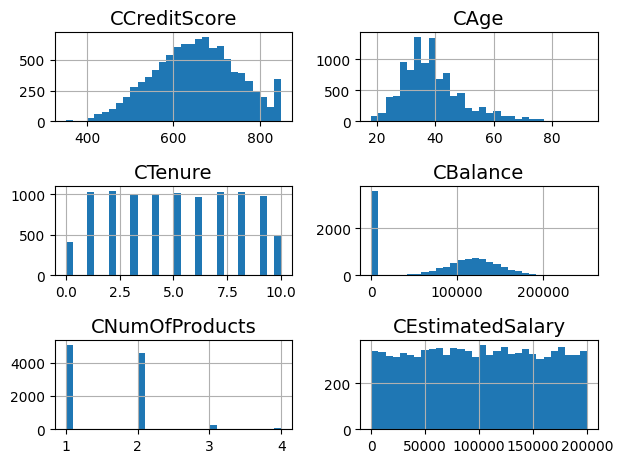

In [22]:
churn.select_dtypes(include=np.number).hist(bins=30)
plt.tight_layout()
plt.show()

Note that the distribution of values in `CAge` column is right-skewed, we will thus also conduct the "log-normalization" on it before scaling. <br/> Now, we are good to build a preprocessing pipeline to include all the above mentioned transformation steps.

In [23]:
#create a preprocessing pipeline containing the transformation of all the categorical features with one-hot encoding;
#"CAge" with a log-transformer and the rest numerical features with standard-scaler
log_pipeline = make_pipeline(FunctionTransformer(np.log, feature_names_out='one-to-one'), StandardScaler())

preprocessing = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_exclude=np.number)),
    ('log', log_pipeline, ['CAge'])
], remainder=StandardScaler(), verbose_feature_names_out=False)

Up to now, we finished EDA and built up a data transformation pipeline. As next, let's train our models.

## Task 1
Apply three different simple machine learning models, which we discussed in lecture 02. Describe your approach, interpret the performance, and justify (based on the results) which machine learning model you would choose.

We will split our dataset into training and test data, launch 3 machine learning models - Decision Trees, k-Nearest Neighbors and Naive Bayes and compare their performance and decide one model for further task 2.<br>
Please note that the performance of the models are evaluated merely on training and validation set, we won't touch the test set until we selected the final single model and are confident to launch it. In other words, we need to use part of the training set for model validation purpose, by conducting cross-validation.

### Split dataset

In [24]:
#split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(churn.iloc[:, :-1], churn.Churn, test_size=0.33, random_state=SEED)

Get view of the transformed traing data.

In [25]:
pd.DataFrame(preprocessing.fit_transform(X_train), columns=preprocessing.get_feature_names_out()).head()

,CGeography_France,CGeography_Germany,CGeography_Spain,CGender_Female,CGender_Male,CHasCrCard_0,CHasCrCard_1,CIsActiveMember_0,CIsActiveMember_1,CAge,CCreditScore,CTenure,CBalance,CNumOfProducts,CEstimatedSalary
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.630469,0.316912,-0.690393,1.161351,0.826993,-0.173820
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.070094,0.316912,1.038040,-0.048373,0.826993,-1.311908
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.014135,-0.086652,-0.344706,0.710798,-0.896187,-1.320959
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.230822,0.068565,1.729413,-1.217735,0.826993,-0.831923
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.511696,-0.666128,1.383727,-1.217735,-0.896187,-1.629335


Our processing pipeline functions well, we can now build and train the models.

In [26]:
#create a Decision Tree classifier object, note that we arbitrarily select min_samples_leaf as 0.04 for now
clf_tree = make_pipeline(preprocessing, DecisionTreeClassifier(min_samples_leaf=0.04, random_state=SEED))
#train the model
clf_tree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c6761a0>),
                                                 ('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CAge'])],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(min_samples_leaf=0.04,
                                        random_state=42))])

In [27]:
#create a KNN classifier object, note that we arbitrarily select n_neighbors as 5 for now
clf_knn = make_pipeline(preprocessing, KNeighborsClassifier(n_neighbors=5))
#train the model
clf_knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c6761a0>),
                                                 ('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CAge'])],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [28]:
#create a Gaussian Classifier
clf_gnb = make_pipeline(preprocessing, GaussianNB())
#train the model
clf_gnb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c6761a0>),
                                                 ('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CAge'])],
                                   verbose_feature_names_out=False)),
                ('gaussiannb', GaussianNB())])

#### Evaluate the 3 models on both training data and validation data
We calculate accuracy, precision, recall, f1 and auc score of the trained model on the whole training data and also conduct 5-fold cross-validation to calculate the respective evaluation metrics by specifying the "scoring" parameter, and display the metrics together. We will create a function to output a dictionary of metrics:

In [29]:
def get_metrics(model, y_pred):
    '''
    output a dictionary containing the model's performance metrics
    on the entire training set and of a 5-fold cross-validation
    by inputting the model and the predicted labels on the train dataset
    '''
    metrics = {
        'accuracy_train' : accuracy_score(y_train, y_pred),
        'accuracy_valid' : cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy').mean(),
        'precision_train' : precision_score(y_train, y_pred),
        'precision_valid' : cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring='precision').mean(),
        'recall_train' : recall_score(y_train, y_pred),
        'recall_valid' : cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring='recall').mean(),
        'f1_train' : f1_score(y_train, y_pred),
        'f1_valid' : cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring='f1').mean(),
        'auc_train': roc_auc_score(y_train, y_pred),
        'auc_valid': cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring='roc_auc').mean(),
    }
    
    return metrics

In [30]:
#evaluate the decision tree model
#predict the label for train dataset
y_pred_train_tree = clf_tree.predict(X_train)

# Calculate model accuracy, precision, recall, f1 and roc_auc score of decision tree
metrics_tree = pd.DataFrame(pd.Series(get_metrics(clf_tree, y_pred_train_tree)), columns=['metrics tree'])

In [31]:
metrics_tree

,metrics tree
accuracy_train,0.822660
accuracy_valid,0.822661
precision_train,0.636020
precision_valid,0.692462
recall_train,0.359687
recall_valid,0.286360
f1_train,0.459509
f1_valid,0.397881
auc_train,0.652553
auc_valid,0.793315


In [32]:
#evaluate the knn model
# Predict the label for train dataset
y_pred_train_knn = clf_knn.predict(X_train)

# Calculate performance metrics of knn
metrics_knn = pd.DataFrame(pd.Series(get_metrics(clf_knn, y_pred_train_knn)), columns=['metrics knn'])

In [33]:
#evaluate the naive bayes model
# Predict the label for train dataset
y_pred_train_gnb = clf_gnb.predict(X_train)

# Calculate performance metrics of naive bayes
metrics_gnb = pd.DataFrame(pd.Series(get_metrics(clf_gnb, y_pred_train_gnb)), columns=['metrics gnb'])

In [34]:
metrics_compare = pd.concat([metrics_tree, metrics_knn, metrics_gnb], axis=1)
metrics_compare

,metrics tree,metrics knn,metrics gnb
accuracy_train,0.822660,0.871772,0.811315
accuracy_valid,0.822661,0.825496,0.811165
precision_train,0.636020,0.788971,0.570707
precision_valid,0.692462,0.632144,0.571498
recall_train,0.359687,0.529915,0.402422
recall_valid,0.286360,0.401007,0.401713
f1_train,0.459509,0.634001,0.472013
f1_valid,0.397881,0.490597,0.471333
auc_train,0.652553,0.746166,0.661079
auc_valid,0.793315,0.775113,0.789602


Let's visualize the performance metrics of the three models:

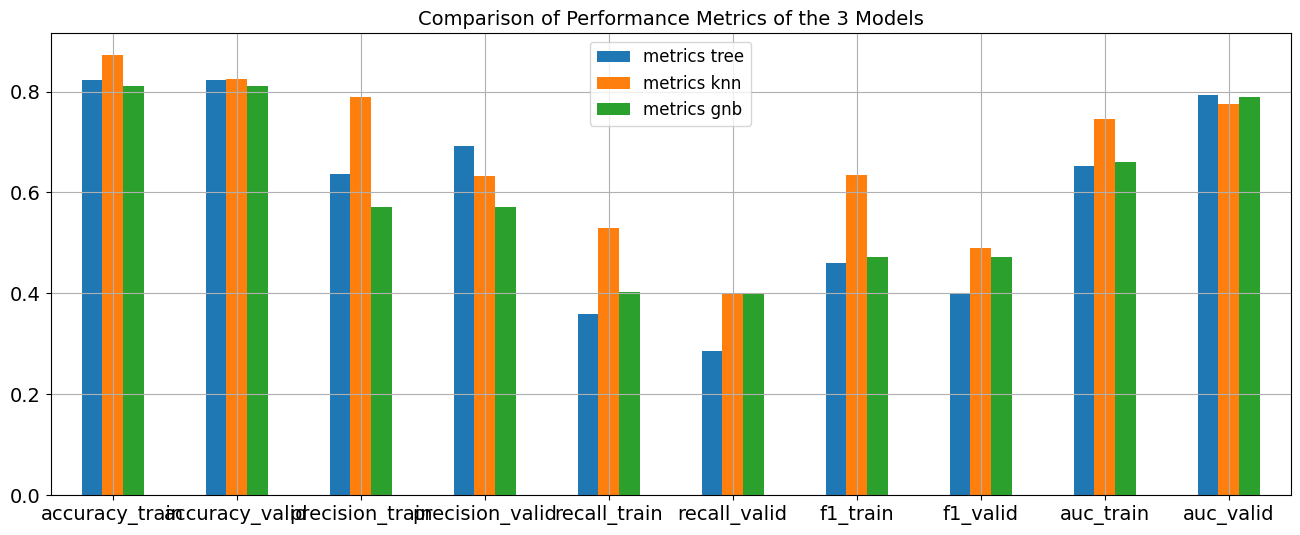

In [35]:
metrics_compare.plot(kind='bar', figsize=(16, 6), grid=True, fontsize=14, rot=0,
                     title='Comparison of Performance Metrics of the 3 Models')
plt.show()

Based on the comparison of the performance metrics of the 3 models above, we can see that both decision tree and knn outperform the naive bayes model, so we won't consider naive bayes afterwards. Although the metrics of knn seems better than that of the decision tree, knn is obviously suffering from overfitting - the metrics on the training data is far better than on the validation data. However, this may also because that we arbitrarily select n_neighbors as 5 to build knn. As follows, we will explore some different n_neighbors to see if this could improve the performance of knn and hopefully also eliminate overfitting.

We will define a function to plot the accuracy scores of knn models trained with different n_neighbors hyperparameter value. Please note that we inspect the accuracy score on the validation data by utilizing cross-validation here, we still do not touch the test set in the model selection phase, until we are confident enough to launch a model!

In [36]:
def elbow(n, n_jobs=-1):
    '''
    plot the accuracy scores of knn models trained with different n_neighbors hyperparameter value
    '''
    accuracy = []
    
    for i in range(1, n+1):
        knn = make_pipeline(preprocessing, KNeighborsClassifier(n_neighbors=i, n_jobs=n_jobs))
        knn.fit(X_train, y_train)
        accuracy.append(cross_val_score(knn, X_train, y_train, cv=3, n_jobs=-1).mean())
        
    plt.figure(figsize=(22, 6))
    plt.gcf().set_size_inches(24, 6)
    plt.plot(range(1,n+1), accuracy, 'b--', marker='o', markerfacecolor='r', markersize=8)
    plt.xticks(range(1, n+1), fontsize=12)
    plt.yticks(fontsize=14)
    plt.title('Accuracy vs K Value')
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()

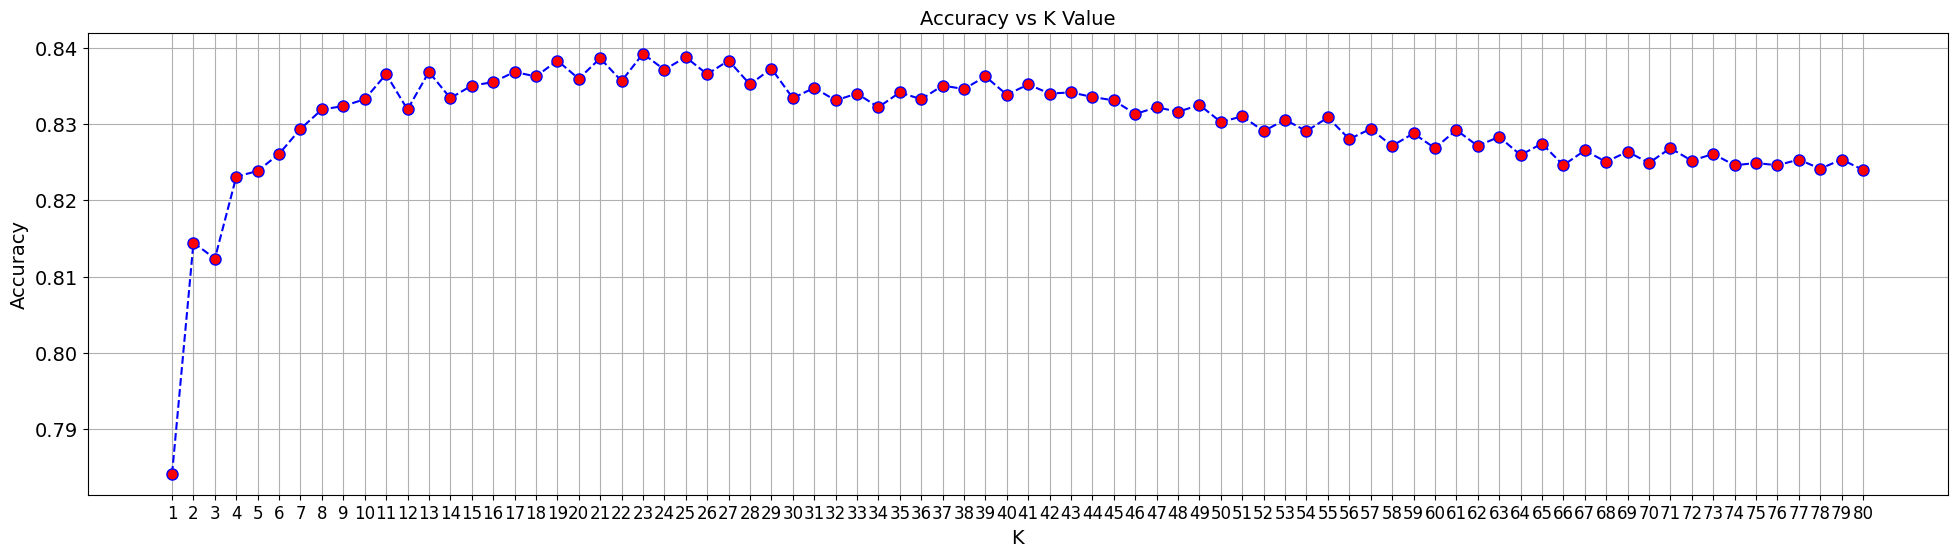

In [37]:
elbow(80)

According to the elbow-chart, we decide `n_neighbors=23` be the best k and calculate the performance metrics based on this:

In [38]:
knn_best = make_pipeline(preprocessing, KNeighborsClassifier(n_neighbors=23, n_jobs=-1))
knn_best.fit(X_train, y_train)

y_pred_train_knn_best = knn_best.predict(X_train)

#calculate performance metrics
metrics_knn_best = pd.DataFrame(pd.Series(get_metrics(knn_best, y_pred_train_knn_best)), columns=['metrics knn best'])

In [39]:
metrics_compare_01 = pd.concat([metrics_compare, metrics_knn_best], axis=1)
metrics_compare_01

,metrics tree,metrics knn,metrics gnb,metrics knn best
accuracy_train,0.822660,0.871772,0.811315,0.850575
accuracy_valid,0.822661,0.825496,0.811165,0.838185
precision_train,0.636020,0.788971,0.570707,0.803008
precision_valid,0.692462,0.632144,0.571498,0.768664
recall_train,0.359687,0.529915,0.402422,0.380342
recall_valid,0.286360,0.401007,0.401713,0.326924
f1_train,0.459509,0.634001,0.472013,0.516191
f1_valid,0.397881,0.490597,0.471333,0.458555
auc_train,0.652553,0.746166,0.661079,0.677801
auc_valid,0.793315,0.775113,0.789602,0.829730


In addition, let's also display the confusion matrix of these 2 models: (Note that we use `cross_val_predict` on training set to perform a k-fold cross-validation to get the "out-of-sample" predictions for each instance).

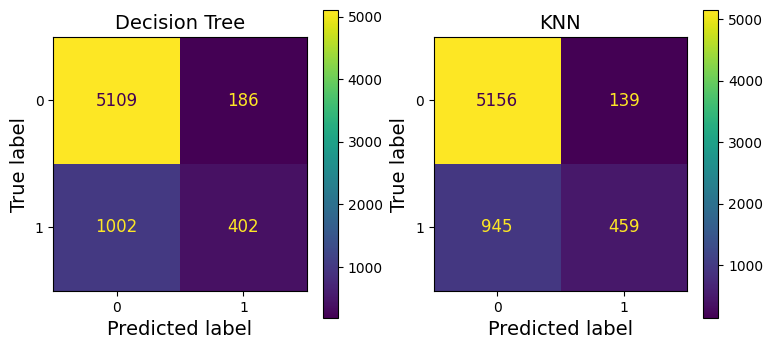

In [40]:
#get the "out-of-sample" predictions
pred_train_tree = cross_val_predict(clf_tree, X_train, y_train, cv=5, n_jobs=1)
pred_train_knn = cross_val_predict(knn_best, X_train, y_train, cv=5, n_jobs=1)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
ConfusionMatrixDisplay.from_predictions(y_train, pred_train_tree, ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_train, pred_train_knn, ax=axs[1])
axs[0].set_title('Decision Tree')
axs[1].set_title('KNN')

plt.show()

The adjusted knn model classifies more instances correctly than the decision tree model, but we shall not ignore the potential risk of the knn model:
although we selected the best number of neighbors for knn (with the hope to eliminate overfitting), the overfitting problem **still exists** (for example, the accuracy on the training data is still much higher than that on the validation data). Based on this knowledge, even though knn performs a bit better than the decision tree model, we will choose our decision tree model in task 1 for the reason that 
1. we won't take the risk of overfitting (as is the case for knn) and
2. we just arbitrarily selected min_samples_leaf=0.04 as the single hyperparameter previously by building the model, we will fine tune hyperparameters on the decision tree model in the next task to make it perform even better.

We will test the fine-tuned decision tree model on the test set only at the end of task 2 when we are confident to launch the model.

## Task 2
Select the machine learning model that you have chosen in task 1. Now try optimizing your results by applying the advanced concepts (lecture 04). Use cross-validation (lecture 04) when evaluating your results. Describe your approach, interpret the performance, and justify which machine learning model you would choose.

In [41]:
pd.DataFrame(preprocessing.fit_transform(X_train), columns=preprocessing.get_feature_names_out(), 
             index=X_train.index).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6699 entries, 5757 to 7271
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CGeography_France   6699 non-null   float64
 1   CGeography_Germany  6699 non-null   float64
 2   CGeography_Spain    6699 non-null   float64
 3   CGender_Female      6699 non-null   float64
 4   CGender_Male        6699 non-null   float64
 5   CHasCrCard_0        6699 non-null   float64
 6   CHasCrCard_1        6699 non-null   float64
 7   CIsActiveMember_0   6699 non-null   float64
 8   CIsActiveMember_1   6699 non-null   float64
 9   CAge                6699 non-null   float64
 10  CCreditScore        6699 non-null   float64
 11  CTenure             6699 non-null   float64
 12  CBalance            6699 non-null   float64
 13  CNumOfProducts      6699 non-null   float64
 14  CEstimatedSalary    6699 non-null   float64
dtypes: float64(15)
memory usage: 837.4 KB


If we look at our transformed training dataset once again as shown above, we don't have the problem of "curse of dimensionality" here, because our number of samples are far more than the number of features. Thus, feature selection and extraction are unnecessary here; Moreover, since we have already used cross-validation technique to evaluate how well our algorithms generalize when trained on a specific dataset in task 1 and detected the overfitting risk of knn model, our focus for this task is to conduct Hyperparameter Tuning to optimize our decision tree model.

We will create a new full pipeline containing the preprocessing steps and the decision tree classifier:

In [42]:
full_pipeline_tree = Pipeline([
    ('preprocessing', preprocessing),
    ('tree', DecisionTreeClassifier(random_state=SEED))
])

We will use grid search cross-validation to tune the `max_leaf_nodes`, `max_depth`, `min_samples_split` and `min_samples_leaf` hyperparameters and then inspect the results.

In [43]:
params = {
    'tree__max_leaf_nodes': list(range(2, 100)),
    'tree__max_depth': list(range(1, 7)),
    'tree__min_samples_split': [2, 3, 4],
    'tree__min_samples_leaf':  [0.003, 0.005, 0.01, 0.04, 0.06, 0.08],
}

grid_search_cv_tree = GridSearchCV(full_pipeline_tree, params, cv=5, n_jobs=-1)
grid_search_cv_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x16c6761a0>),
                                                                        ('log',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='...
                                                                         ['CAge'])],
                                                          verbose_feature_names_out=False)),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 2, 3, 4, 5, 6],
                         'tree__max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                                  18, 19, 20, 21, 22, 23, 24,
                                                  25, 26, 27, 28, 29, 30, 31, ...],
                         'tree__min_samples_leaf': [0.003, 0.005, 0.01, 0.04,
                                                    0.06, 0.08],
                         'tree__min_samples_split': [2, 3, 4]})

In [44]:
#show the best hyperparameters
grid_search_cv_tree.best_params_

{'tree__max_depth': 5,
 'tree__max_leaf_nodes': 10,
 'tree__min_samples_leaf': 0.003,
 'tree__min_samples_split': 2}

Now that we can get our finally optimized decision tree model with the best hyperparameters, we can access the best estimator using `best_estimator_` (Note that `GridSearchCV` finds the best estimator and retrains the model on the whole training set, because the `refit` parameter is True by default). We will evaluate the performance of the final model as we did in task 1.

In [45]:
final_tree = grid_search_cv_tree.best_estimator_

In [46]:
#evaluate the final model
#predict the label for train dataset
y_pred_tree = final_tree.predict(X_train)

# Calculate performance metrics
metrics_final_tree = pd.DataFrame(pd.Series(get_metrics(final_tree, y_pred_tree)), columns=['metrics final tree'])

metrics_compare_02 = pd.concat([metrics_compare_01, metrics_final_tree], axis=1)
metrics_compare_02

,metrics tree,metrics knn,metrics gnb,metrics knn best,metrics final tree
accuracy_train,0.822660,0.871772,0.811315,0.850575,0.848186
accuracy_valid,0.822661,0.825496,0.811165,0.838185,0.851173
precision_train,0.636020,0.788971,0.570707,0.803008,0.754271
precision_valid,0.692462,0.632144,0.571498,0.768664,0.749444
recall_train,0.359687,0.529915,0.402422,0.380342,0.408832
recall_valid,0.286360,0.401007,0.401713,0.326924,0.437331
f1_train,0.459509,0.634001,0.472013,0.516191,0.530254
f1_valid,0.397881,0.490597,0.471333,0.458555,0.551771
auc_train,0.652553,0.746166,0.661079,0.677801,0.686758
auc_valid,0.793315,0.775113,0.789602,0.829730,0.808483


The accuracy score on the validation data of our final model is even better than the previous knn with the best number of neighbors, which indicates a good generalization ability! More importantly, our optimized decision tree doesn't suffer from overfitting. Let's display the confusion matrices of the decision tree before and after hyperparameter tuning:

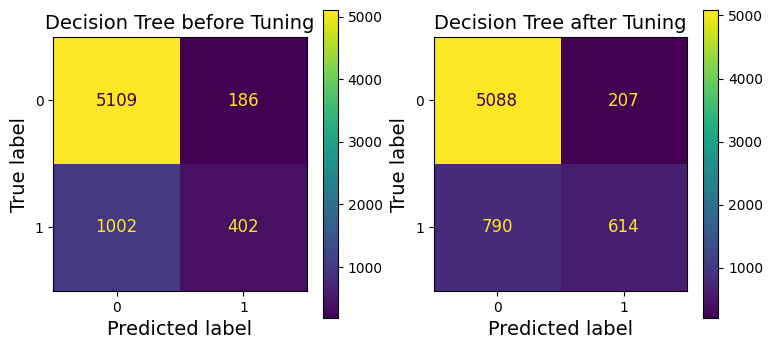

In [47]:
#get the "out-of-sample" predictions
pred_train_final_tree = cross_val_predict(final_tree, X_train, y_train, cv=5, n_jobs=1)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
ConfusionMatrixDisplay.from_predictions(y_train, pred_train_tree, ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_train, pred_train_final_tree, ax=axs[1])
axs[0].set_title('Decision Tree before Tuning')
axs[1].set_title('Decision Tree after Tuning')

plt.show()

Also on the above confusion matrix we can see the increase of the correctly classified samples after tuning: (5088+614) > (5109+402). 

Now we are confident to check the final model's performance on the test set:

In [48]:
pred_test_final_tree = final_tree.predict(X_test)

# Calculate the metrics on the test set
metrics_test_tree = {
    'accuracy_test': accuracy_score(y_test, pred_test_final_tree),
    'precision_test': precision_score(y_test, pred_test_final_tree),
    'recall_test': recall_score(y_test, pred_test_final_tree),
    'f1': f1_score(y_test, pred_test_final_tree)
}
metrics_test_tree = pd.DataFrame(pd.Series(metrics_test_tree), columns=['decision tree test data perform'])
metrics_test_tree

,decision tree test data perform
accuracy_test,0.853636
precision_test,0.730650
recall_test,0.373418
f1,0.494241


The model accuracy on test data is even better! Finally, we display the confusion matrix of the model on the test data.

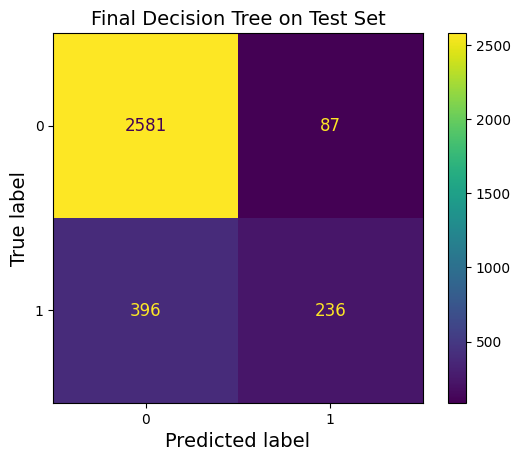

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_test_final_tree)
plt.title('Final Decision Tree on Test Set')
plt.show()

Based on the analysis, tuning and evaluation above, we would choose `final_tree` as our final model.

## Task 3
Apply one ensemble learning technique (lecture 05) to see whether those techniques lead to a better performance than in task 1 and task 2. You should also apply the advanced concepts (lecture 04) to improve the model. Describe your approach, interpret the performance, and justify the final machine learning selection.

In this task, we will train a random forest (RF), evaluate it and tune the hyperparameters by performing randomized search.

In [50]:
#create a pipeline for the random forest classifier
full_pipeline_rf = Pipeline([
    ('preprocessing', preprocessing),
    ('forest', RandomForestClassifier(random_state=SEED))
])

#train the model
full_pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c6761a0>),
                                                 ('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CAge'])],
                                   verbose_feature_names_out=False)),
                ('forest', RandomForestClassifier(random_state=42))])

In [51]:
#predict the label for train dataset
y_pred_rf_untuned = full_pipeline_rf.predict(X_train)

# Calculate performance metrics
pd.DataFrame(pd.Series(get_metrics(full_pipeline_rf, y_pred_rf_untuned)), columns=['metrics rf untuned'])

,metrics rf untuned
accuracy_train,1.000000
accuracy_valid,0.850723
precision_train,1.000000
precision_valid,0.741062
recall_train,1.000000
recall_valid,0.444431
f1_train,1.000000
f1_valid,0.555184
auc_train,1.000000
auc_valid,0.840323


Obviously, the random forest model is severely overfitted with an accuracy of 1 on training data and 0.85 on validation data. We have to conduct hyperparameter tuning on it to tackle overfitting by constraining the `max_features` and `max_depth` parameter with the help of randomized search to reduce model complexity and thus reduce variance.

In [52]:
param_distribs = {
    'forest__max_features': stats.randint(2, 16),
    'forest__max_depth': stats.randint(1, 7)
}

random_search_cv_rf = RandomizedSearchCV(full_pipeline_rf, param_distribs, 
                                       n_iter=10, cv=5, n_jobs=-1, random_state=SEED)
random_search_cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x16c6761a0>),
                                                                              ('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names...
                                                                                                StandardScaler())]),
                                                                               ['CAge'])],
                                                                verbose_feature_names_out=False)),
                                             ('forest',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'forest__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17797ff70>,
                                        'forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x175374a30>},
                   random_state=42)

In [53]:
#the best hyperparameters
random_search_cv_rf.best_params_

{'forest__max_depth': 5, 'forest__max_features': 5}

Now that we can get our finally optimized random forest model with its best hyperparameters, we can access the best estimator using `best_estimator_`. We can then evaluate the performance of the final model as we did in task 2.

In [54]:
final_rf = random_search_cv_rf.best_estimator_

In [55]:
#evaluate the final model
#predict the label for train dataset
y_pred_rf = final_rf.predict(X_train)

# Calculate performance metrics
metrics_final_rf = pd.DataFrame(pd.Series(get_metrics(final_rf, y_pred_rf)), columns=['metrics final random forest'])

metrics_compare_03 = pd.concat([metrics_compare_02, metrics_final_rf], axis=1)
metrics_compare_03

,metrics tree,metrics knn,metrics gnb,metrics knn best,metrics final tree,metrics final random forest
accuracy_train,0.822660,0.871772,0.811315,0.850575,0.848186,0.859083
accuracy_valid,0.822661,0.825496,0.811165,0.838185,0.851173,0.853561
precision_train,0.636020,0.788971,0.570707,0.803008,0.754271,0.826705
precision_valid,0.692462,0.632144,0.571498,0.768664,0.749444,0.801761
recall_train,0.359687,0.529915,0.402422,0.380342,0.408832,0.414530
recall_valid,0.286360,0.401007,0.401713,0.326924,0.437331,0.403142
f1_train,0.459509,0.634001,0.472013,0.516191,0.530254,0.552182
f1_valid,0.397881,0.490597,0.471333,0.458555,0.551771,0.535624
auc_train,0.652553,0.746166,0.661079,0.677801,0.686758,0.695745
auc_valid,0.793315,0.775113,0.789602,0.829730,0.808483,0.852077


Let's also display the confusion matrices of the decision tree and random forest:

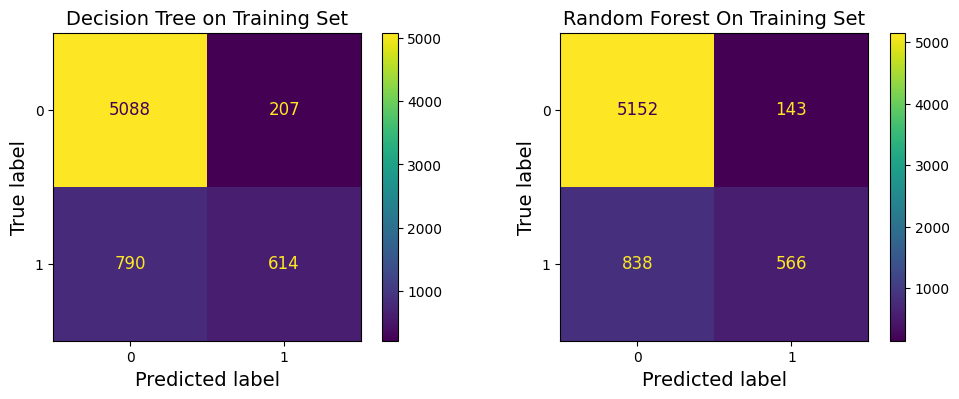

In [56]:
#get the "out-of-sample" predictions
pred_train_rf = cross_val_predict(final_rf, X_train, y_train, cv=5, n_jobs=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ConfusionMatrixDisplay.from_predictions(y_train, pred_train_final_tree, ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_train, pred_train_rf, ax=axs[1])
axs[0].set_title('Decision Tree on Training Set')
axs[1].set_title('Random Forest On Training Set')

plt.show()

Both the list of the performance metrics and the confusion matrix indicate that the accuracy score on both training and validation data of our finally tuned random forest model is better than the decision tree. Our model's performance get further improved after the tuning, overfitting is no more a problem.

Now we are confident to check the final model's performance on the test set and display the results together with the results from task 2:

In [57]:
pred_test_final_rf = final_rf.predict(X_test)

# Calculate the metrics on the test set
metrics_test_rf = {
    'accuracy_test': accuracy_score(y_test, pred_test_final_rf),
    'precision_test': precision_score(y_test, pred_test_final_rf),
    'recall_test': recall_score(y_test, pred_test_final_rf),
    'f1': f1_score(y_test, pred_test_final_rf)
}
metrics_test_rf = pd.DataFrame(pd.Series(metrics_test_rf), columns=['random forest test data perform'])

metrics_compare_test_final = pd.concat([metrics_test_tree, metrics_test_rf], axis=1)
metrics_compare_test_final

,decision tree test data perform,random forest test data perform
accuracy_test,0.853636,0.866061
precision_test,0.730650,0.802548
recall_test,0.373418,0.398734
f1,0.494241,0.532770


We can see that all of the four performance metrics get improved with the random forest model. Also, let's display the confusion matrices of both model's outputs on the test dataset:

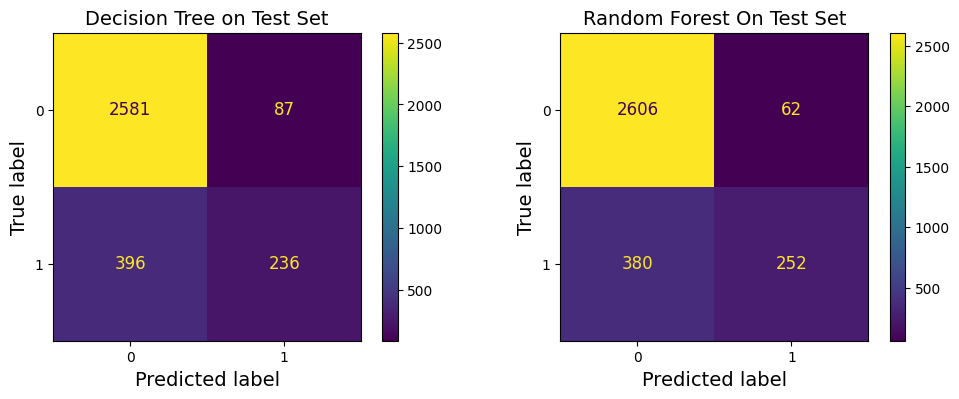

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ConfusionMatrixDisplay.from_predictions(y_test, pred_test_final_tree, ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_test, pred_test_final_rf, ax=axs[1])
axs[0].set_title('Decision Tree on Test Set')
axs[1].set_title('Random Forest On Test Set')

plt.show()

With more instances classified correctly, our random forest model also outperforms the decision tree model on the test set. 

Lastly, let's also compare the auc score of these models on test set:

In [59]:
#Compute the area under ROC curve
print("Decision Tree - Area Under Curve:", roc_auc_score(y_test, pred_test_final_tree))
print("Random Forest - Area Under Curve:", roc_auc_score(y_test, pred_test_final_rf))

Decision Tree - Area Under Curve: 0.6704045129334066
Random Forest - Area Under Curve: 0.6877478982027974


To conclude, random forest has the best model performance. We finally select the random forest as our machine learning model to deploy in production.

## Further thoughts
So far, we have selected our final model to launch, which achieved good performance as far as accuracy score is concerned. But if we look at the recall scores of our model on training and test set, they are just around 40%, meaning that the ability of our model to detect positives is limited. Let's think one step further: imagine that as our startup grows and makes more profit, the leadership of the company would emphasize the ability of our model to identify churned customers in the future and thus decides to allocate enough resources into marketing activities to prevent customers from leaving, even at the cost of identifying customers who are actually not leaving as disloyal, i.e., the company is willing to take the risk of getting more false positives. In that case, our current model's recall is too low for this business purpose, so it would be nice that we have a "back-up model" - a modified version of our final model that satisfies this potential business requirement. Let's assume that our boss would be happy to have a model that delivers roughly 75% recall.

One approach is to try further optimization on our model's hyperparameters to see if recall score could be improved. To let `RandomizedSearchCV` focus more on by recall score, we will apply multiple metric evaluation, where we set the parameter **"refit='recall'"** to denote the scorer, i.e. "recall rate", would be used to find the best parameters for refitting the estimator at the end. Let's see if this works:

In [60]:
param_distribs = {
    'forest__max_features': stats.randint(2, 16),
    'forest__max_depth': stats.randint(1, 7),
}

scorers = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score)
}

#specify to focus on recall rate
try_random_search_cv_rf = RandomizedSearchCV(full_pipeline_rf, param_distribs, scoring=scorers, refit='recall',
                                       n_iter=10, cv=5, n_jobs=-1, random_state=SEED)
try_random_search_cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x16c6761a0>),
                                                                              ('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names...
                   param_distributions={'forest__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177a860b0>,
                                        'forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177a6db10>},
                   random_state=42, refit='recall',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score)})

In [61]:
#display the best hyperparameters in this case
try_random_search_cv_rf.best_params_

{'forest__max_depth': 3, 'forest__max_features': 12}

In [62]:
#get the best model
try_rf = try_random_search_cv_rf.best_estimator_

Let's also display the performance metrics of this model on the training set:

In [63]:
#predict the label for train dataset
try_y_pred_rf = try_rf.predict(X_train)

# Calculate model accuracy, precision, recall and f1 score
metrics_try_rf = pd.DataFrame(pd.Series(get_metrics(try_rf, try_y_pred_rf)), columns=['metrics try random forest'])
pd.concat([metrics_compare_03, metrics_try_rf], axis=1)

,metrics tree,metrics knn,metrics gnb,metrics knn best,metrics final tree,metrics final random forest,metrics try random forest
accuracy_train,0.822660,0.871772,0.811315,0.850575,0.848186,0.859083,0.848933
accuracy_valid,0.822661,0.825496,0.811165,0.838185,0.851173,0.853561,0.846693
precision_train,0.636020,0.788971,0.570707,0.803008,0.754271,0.826705,0.742574
precision_valid,0.692462,0.632144,0.571498,0.768664,0.749444,0.801761,0.735085
recall_train,0.359687,0.529915,0.402422,0.380342,0.408832,0.414530,0.427350
recall_valid,0.286360,0.401007,0.401713,0.326924,0.437331,0.403142,0.424502
f1_train,0.459509,0.634001,0.472013,0.516191,0.530254,0.552182,0.542495
f1_valid,0.397881,0.490597,0.471333,0.458555,0.551771,0.535624,0.537270
auc_train,0.652553,0.746166,0.661079,0.677801,0.686758,0.695745,0.694034
auc_valid,0.793315,0.775113,0.789602,0.829730,0.808483,0.852077,0.827751


Let's also display the performance metrics of this model on the test set:

In [64]:
pred_test_try_rf = try_rf.predict(X_test)

# Calculate the metrics on the test set
try_metrics_test_rf = {
    'accuracy_test': accuracy_score(y_test, pred_test_try_rf),
    'precision_test': precision_score(y_test, pred_test_try_rf),
    'recall_test': recall_score(y_test, pred_test_try_rf),
    'f1': f1_score(y_test, pred_test_try_rf)
}
try_metrics_test_rf = pd.DataFrame(pd.Series(try_metrics_test_rf), columns=['try random forest test data perform'])

pd.concat([metrics_test_tree, metrics_test_rf, try_metrics_test_rf], axis=1)

,decision tree test data perform,random forest test data perform,try random forest test data perform
accuracy_test,0.853636,0.866061,0.856061
precision_test,0.730650,0.802548,0.718663
recall_test,0.373418,0.398734,0.408228
f1,0.494241,0.532770,0.520686


Well, this optimized model indeed improved the recall score, but is still far from our expectation (roughly 75% recall). 

Let's try another approach: we use `cross_val_predict` on training set to perform a k-fold cross-validation to get the "out-of-sample" predictions of class probabilities for each instance, and we will just use the probabilities of the positive class as scores. We will than tune the decision threshold of the model (which is 0.5 by default in random forest, meaning that if an instance has a predicted probability above 0.5, it would be predicted as positive, i.e., churned in our model, otherwise not churned.) to adjust the recall score.

Let's have a look at our current model's precision recall curve:

In [65]:
#note that we predict the class probability here
y_scores_train = cross_val_predict(final_rf, X_train, y_train, method='predict_proba', n_jobs=-1)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_train)

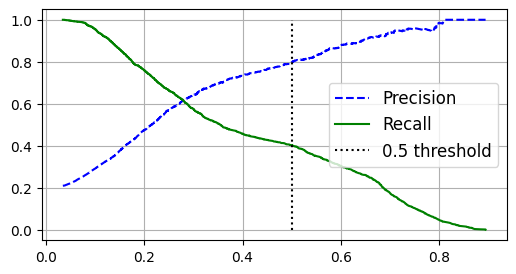

In [66]:
#also display the default threshold for the model to make prediction
threshold = 0.5

plt.figure(figsize=(6, 3))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='0.5 threshold')
plt.grid()
plt.legend(loc="center right")
plt.show()

At a threshold value of 0.5, precision is near 80% and recall is around 40%, which corresponds our evaluation results up to now. We then do the adjustment:

In [67]:
def get_threshold(recalls, thresholds, desired_recall):
    '''
    returns a decision threshold to achieve the desired recall score
    by inputting the recall- and threshold-list and the target recall
    '''
    idx_desired_recall = (recalls <= desired_recall/100).argmax()
    return thresholds[idx_desired_recall]

In [68]:
#get the decision threshold of 75%-recall
threshold_75_recall = get_threshold(recalls, thresholds, 75)
threshold_75_recall

0.20420810562401928

Now that we find the decision threshold on the predicted instance scores that finally lead to our target recall value, we can inspect this on our training set. Customers with a score above the new threshold (instead of 0.5) will now be classified as churned.

In [69]:
y_train_pred_75 = (y_scores_train >= threshold_75_recall)

#display the performance metrics
print(classification_report(y_train, y_train_pred_75))

              precision    recall  f1-score   support

           0       0.92      0.78      0.85      5295
           1       0.48      0.75      0.58      1404

    accuracy                           0.78      6699
   macro avg       0.70      0.77      0.72      6699
weighted avg       0.83      0.78      0.79      6699



We achieved 75% recall, and an accuracy of 78% is still satisfactory. Let's also try this new model on the test set:

In [70]:
y_test_pred_75 = (final_rf.predict_proba(X_test)[:,1] >= threshold_75_recall)

print(classification_report(y_test, y_test_pred_75))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2668
           1       0.46      0.73      0.56       632

    accuracy                           0.78      3300
   macro avg       0.69      0.76      0.71      3300
weighted avg       0.84      0.78      0.80      3300



This threshold also delivers good result (regarding both recall and accuracy) on the test set. Now we have a back-up model just in case that future business strategy requires higher recall rate.